# Final Project – Introduction to Machine Learning (Group 32)
## Loan Approval Prediction – Binary Classification
**Tamar & Tala – Spring 2025**

This notebook walks through our end-to-end machine learning project:
- Data exploration 
- Feature processing 
- Model training 
- Evaluation 
- Final prediction submission 

## 1. Load Libraries and Data
_We’ll start by loading the data and setting up useful libraries._

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

import missingno as msno


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Load the data
train = pd.read_csv('train.csv', na_values=["?"])
test = pd.read_csv('test.csv', na_values=["?"])
train.head()

,customer_id,Age,Employment_Type,A,Education_Level,Years_of_Education,Marital_Status,Job_Type,Household_Role,Ethnicity,...,Investment_Gain,Investment_Loss,Weekly_Work_Hours,Country_of_Residence,C,Preferred_Communication_Method,D,B,E,Loan_Approval
0,115892,90.0,NaN,77053,HS-grad,9.0,Widowed,NaN,Not-in-family,White,...,0.0,4356.0,40,United-States,104.906221,Phone_Call,2.865629,NaN,170.887465,0
1,115893,82.0,Private,132870,HS-grad,9.0,Widowed,Exec-managerial,Not-in-family,White,...,0.0,4356.0,18,United-States,96.358501,mail,5.528583,NaN,156.630201,0
2,115895,54.0,Private,140359,7th-8th,4.0,Divorced,Machine-op-inspct,Unmarried,White,...,0.0,3900.0,40,United-States,115.529631,mail,3.816915,NaN,165.635557,0
3,115896,41.0,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,...,0.0,3900.0,40,United-States,85.732506,NaN,5.416363,NaN,123.379007,0
4,115897,34.0,Private,216864,HS-grad,9.0,Divorced,Other-service,Unmarried,White,...,NaN,3770.0,45,United-States,115.218443,Mail,6.453932,NaN,155.262131,0


## 2. Exploratory Data Analysis (EDA)
_Let's understand the data structure, spot missing values, and explore correlations._


**Answer in markdown:**
- Are there outliers?
- Are there missing values?
- Any early ideas on important features?

In [3]:
n_rows,n_columns = train.shape
(n_rows,n_columns)

(27676, 21)

In [4]:
train.describe()

,customer_id,Age,A,Years_of_Education,Investment_Gain,Investment_Loss,Weekly_Work_Hours,C,D,B,E,Loan_Approval
count,27676.000000,27541.000000,2.767600e+04,27122.000000,26846.000000,27647.000000,27676.000000,26561.000000,27676.000000,0.0,24389.000000,27676.000000
mean,132196.289854,38.597727,1.898849e+05,10.079972,1091.680101,86.084458,40.482151,99.957601,4.987450,NaN,139.251615,0.240786
std,9399.839425,13.636965,1.053593e+05,2.575332,7482.292675,400.504134,12.371156,9.911054,1.511751,NaN,13.708225,0.427569
min,115892.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,58.136513,-1.711896,NaN,82.675954,0.000000
25%,124043.750000,28.000000,1.177652e+05,9.000000,0.000000,0.000000,40.000000,93.273986,3.968762,NaN,129.783073,0.000000
50%,132222.500000,37.000000,1.785870e+05,10.000000,0.000000,0.000000,40.000000,99.903569,4.994815,NaN,139.078247,0.000000
75%,140322.500000,48.000000,2.376340e+05,12.000000,0.000000,0.000000,45.000000,106.636563,5.999440,NaN,148.488675,0.000000
max,148452.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,144.309842,10.876204,NaN,199.134411,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27676 entries, 0 to 27675
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     27676 non-null  int64  
 1   Age                             27541 non-null  float64
 2   Employment_Type                 25865 non-null  object 
 3   A                               27676 non-null  int64  
 4   Education_Level                 27676 non-null  object 
 5   Years_of_Education              27122 non-null  float64
 6   Marital_Status                  27676 non-null  object 
 7   Job_Type                        24305 non-null  object 
 8   Household_Role                  27676 non-null  object 
 9   Ethnicity                       24912 non-null  object 
 10  Gender                          27676 non-null  object 
 11  Investment_Gain                 26846 non-null  float64
 12  Investment_Loss                 

Column B is completely empty (100% missing), so we will remove it from the dataset.
Several columns, such as Employment_Type, Job_Type and Ethnicity have a high percentage of missing values.
We'll need to decide whether to fill them or drop them.

_Visualizing the variables to check their distributions:_

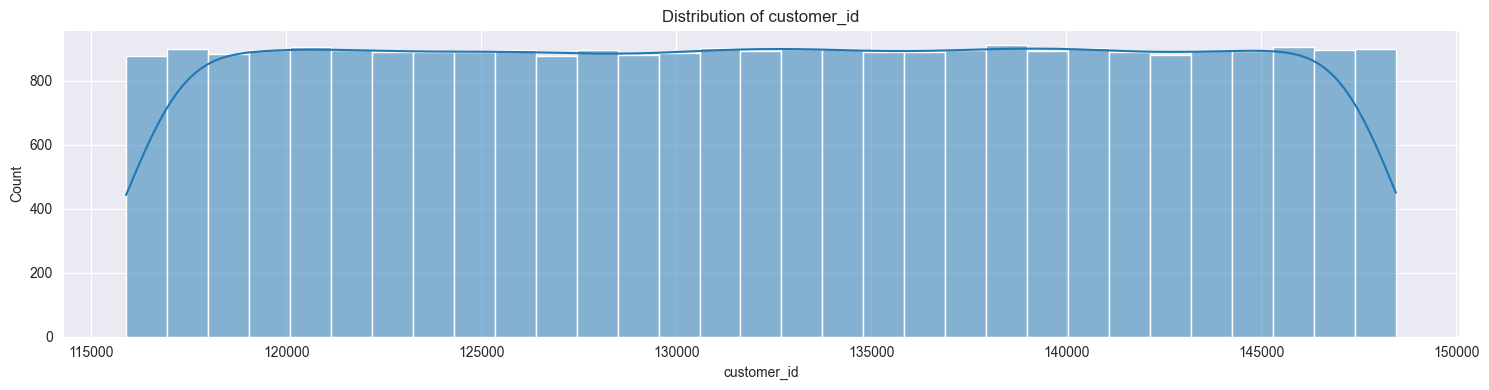

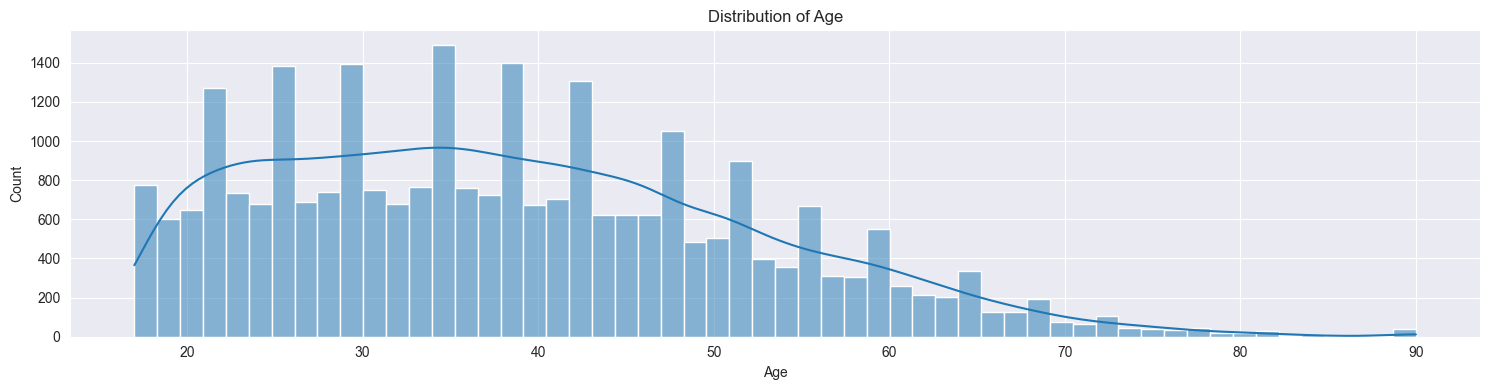

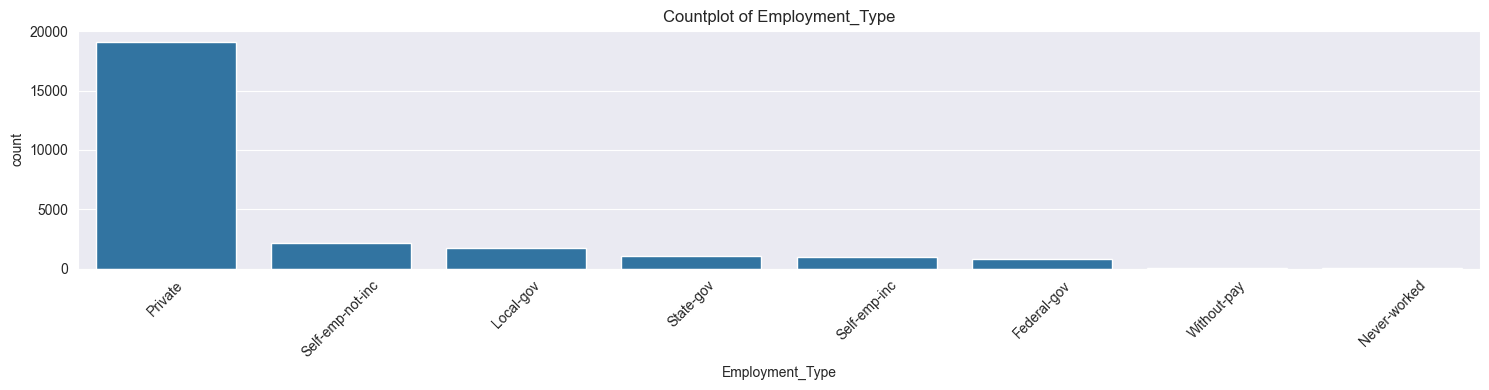

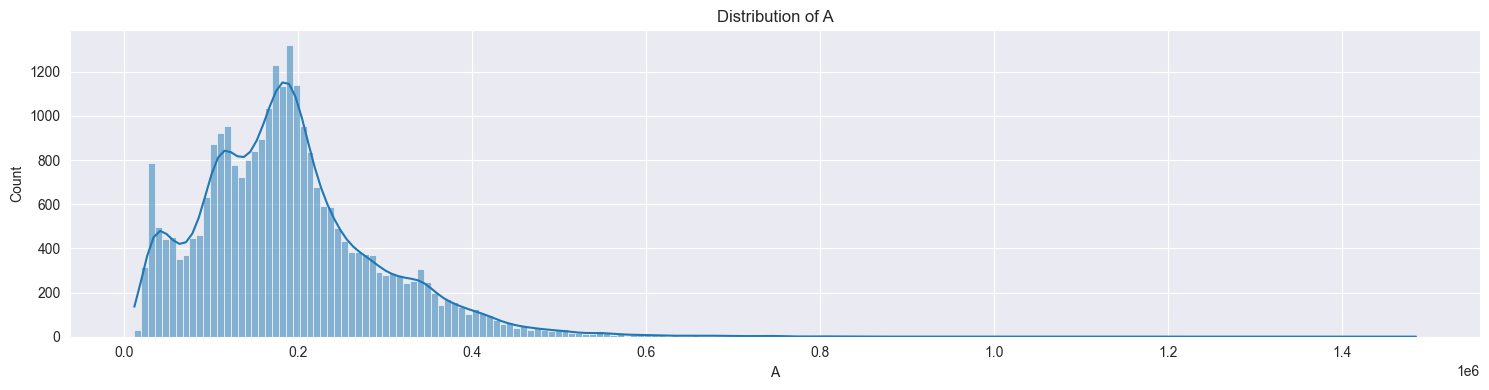

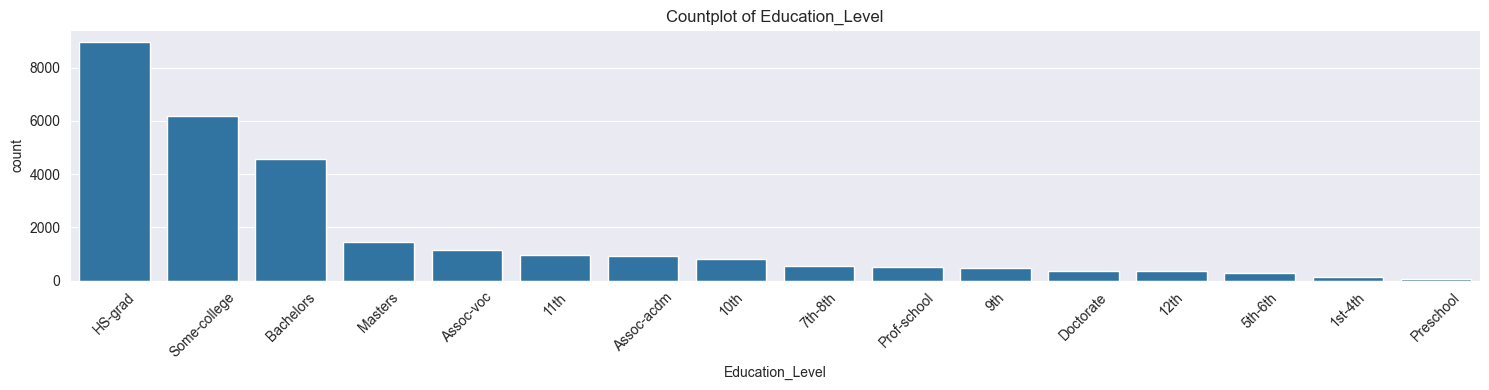

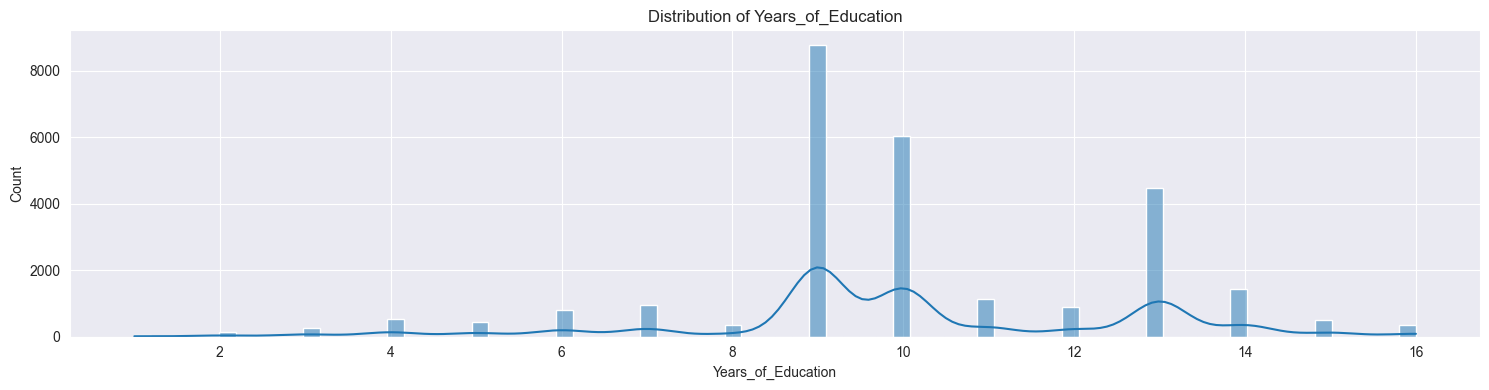

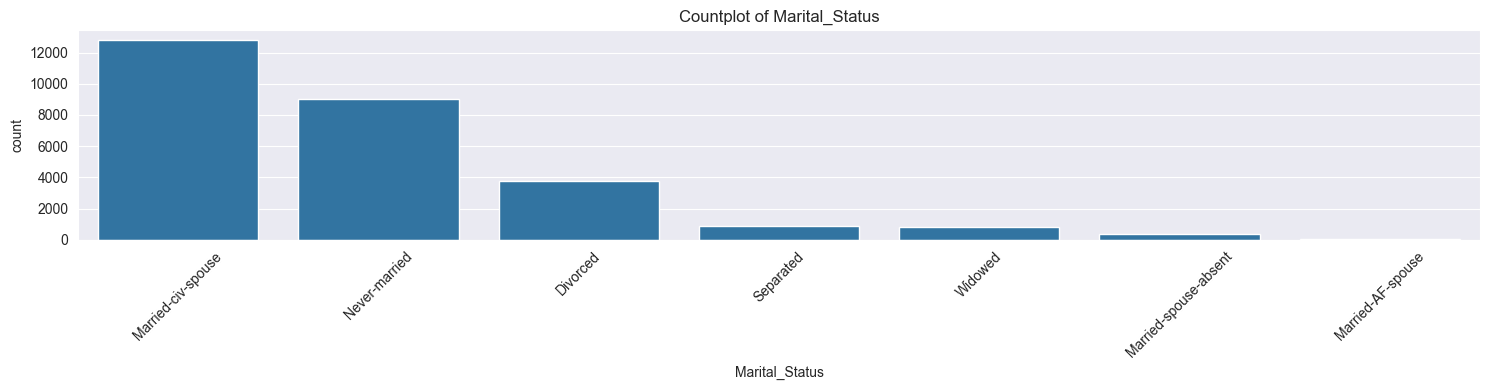

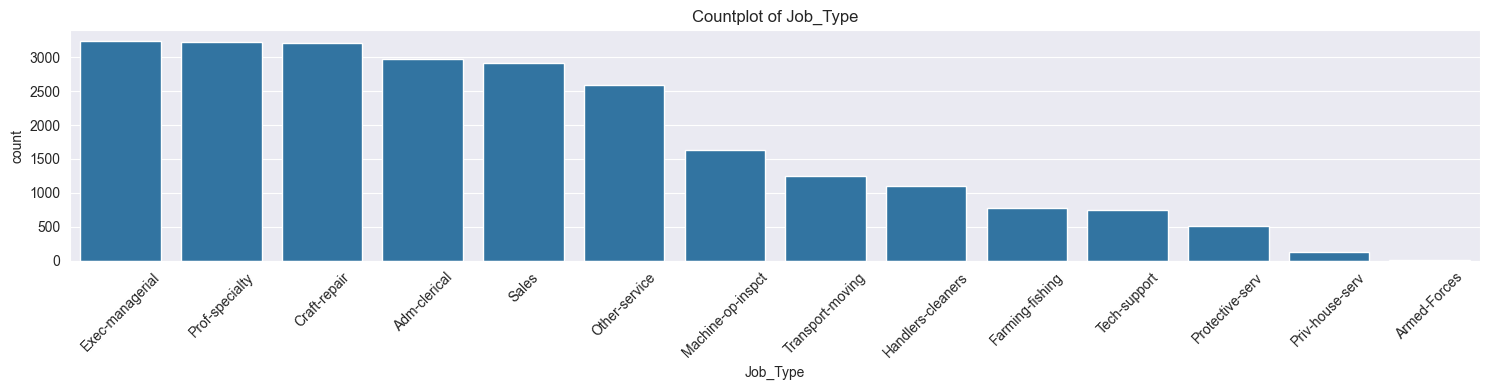

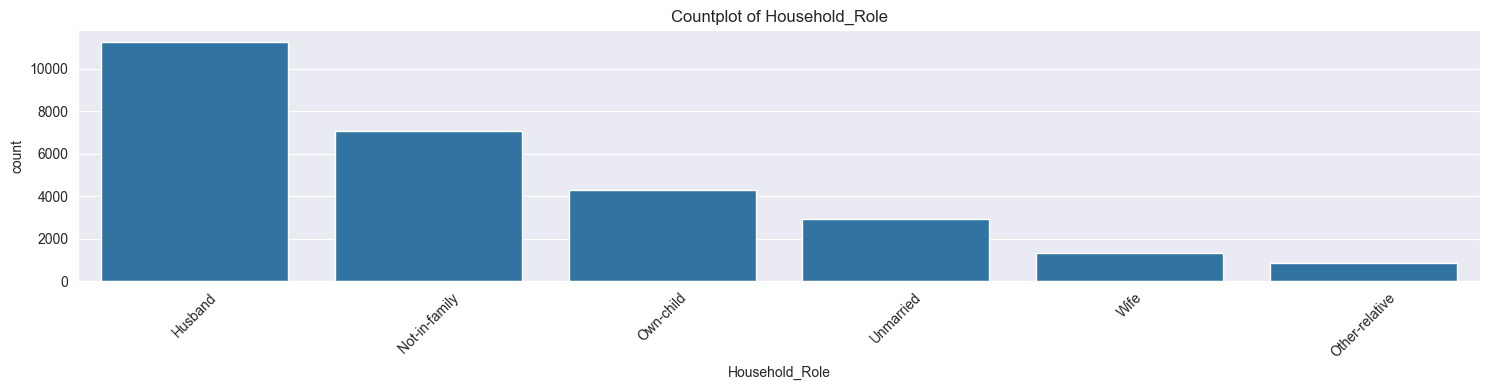

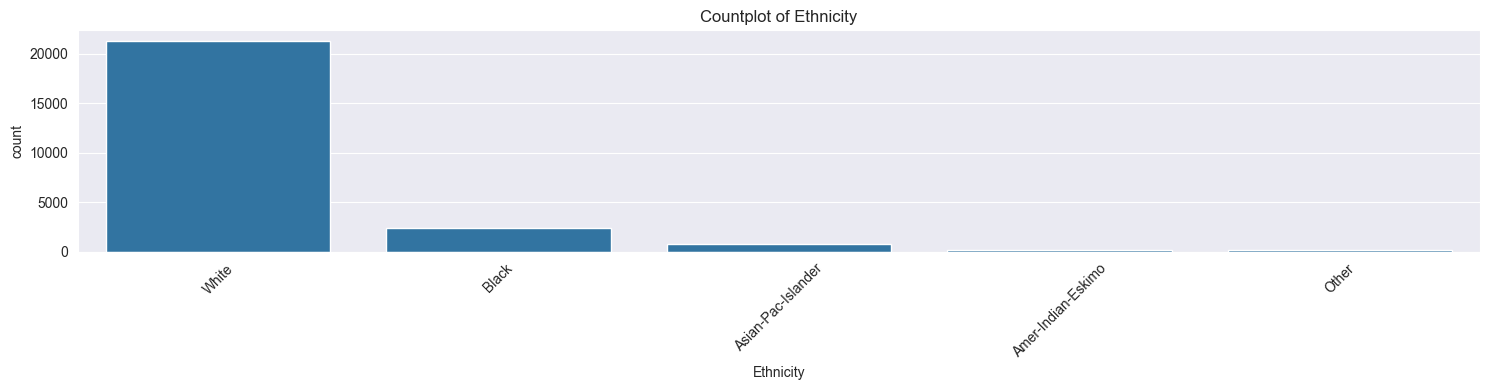

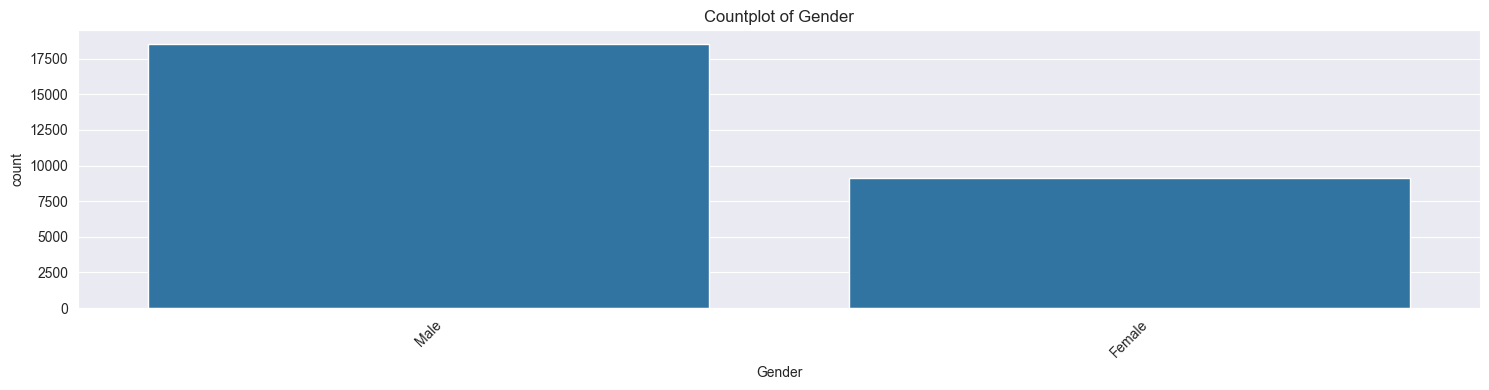

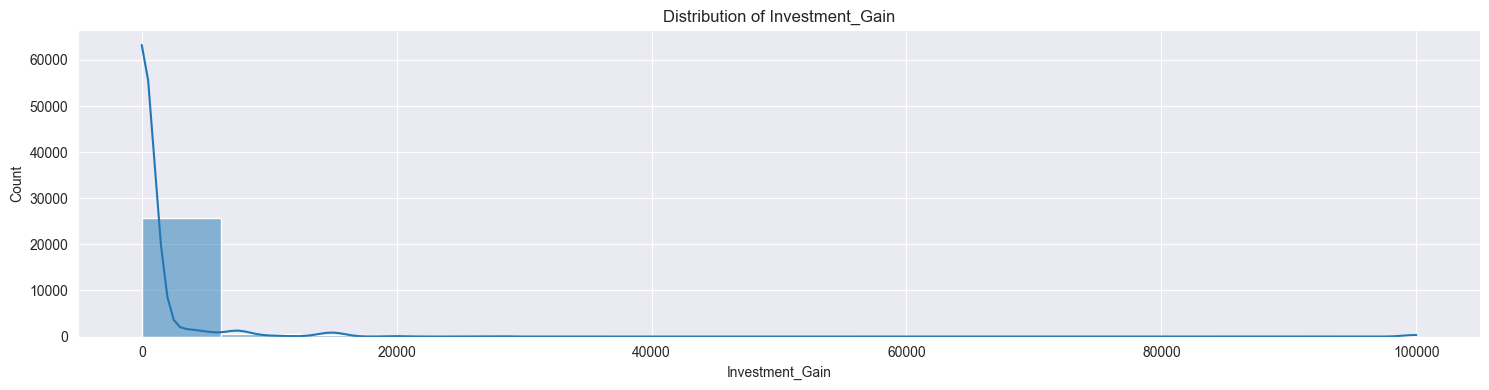

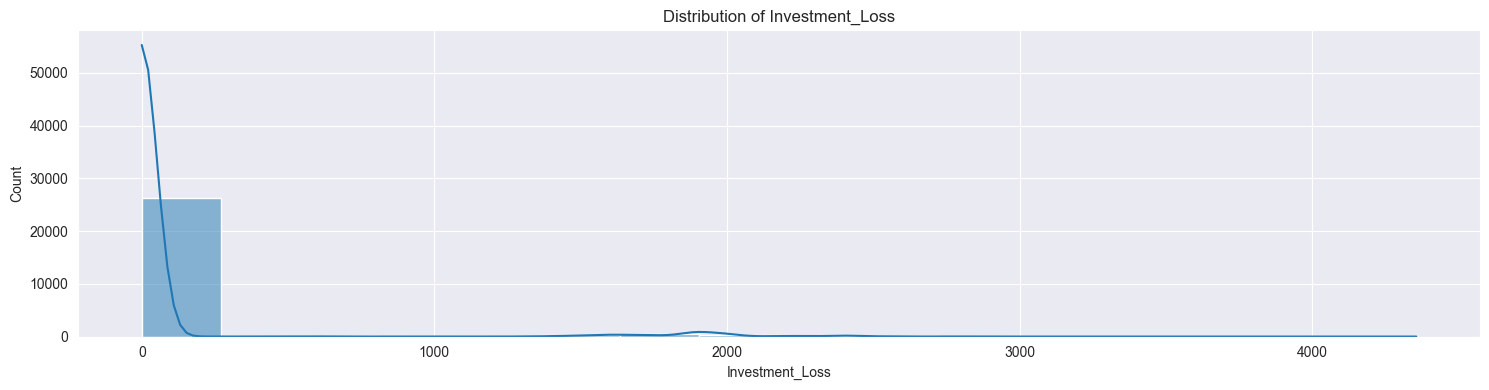

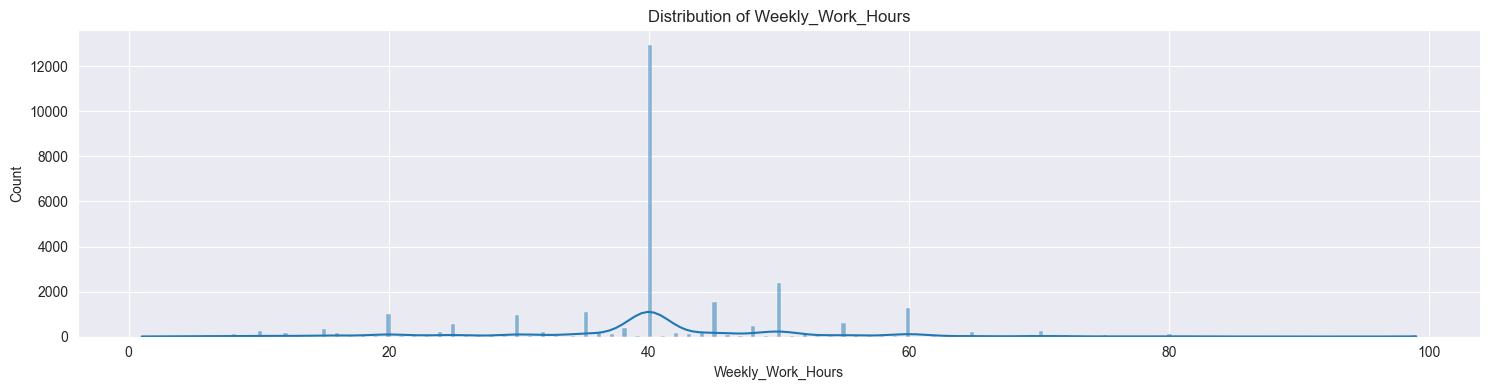

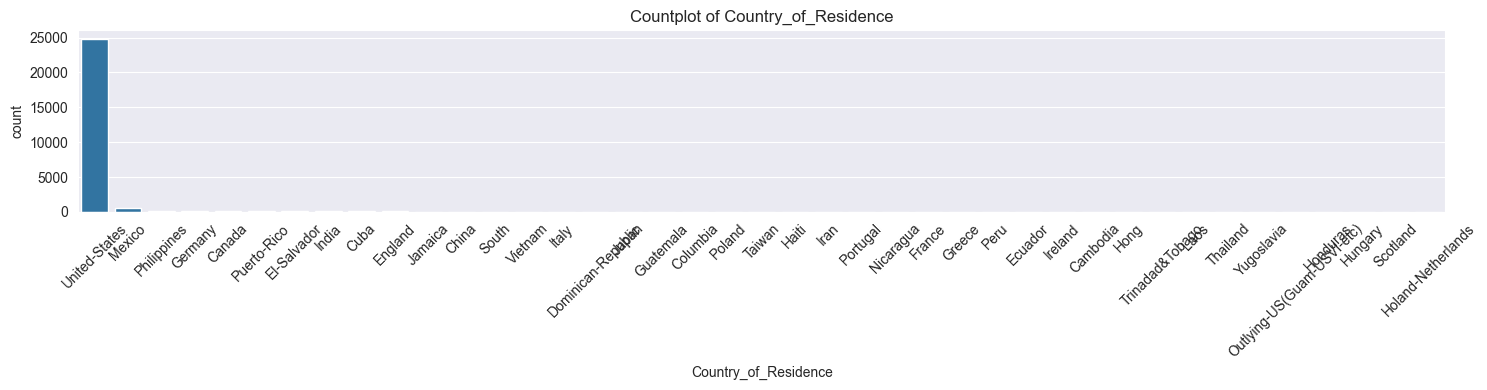

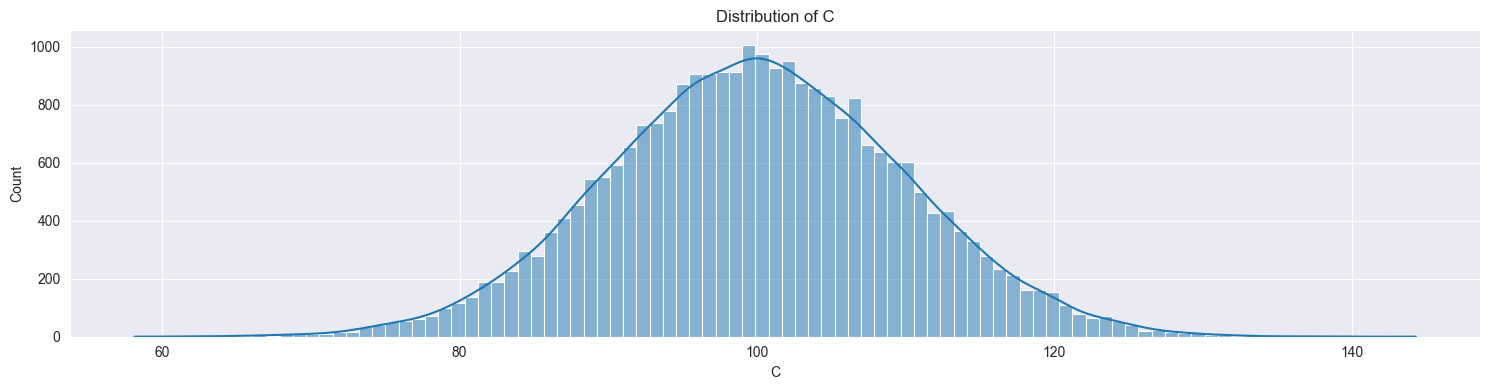

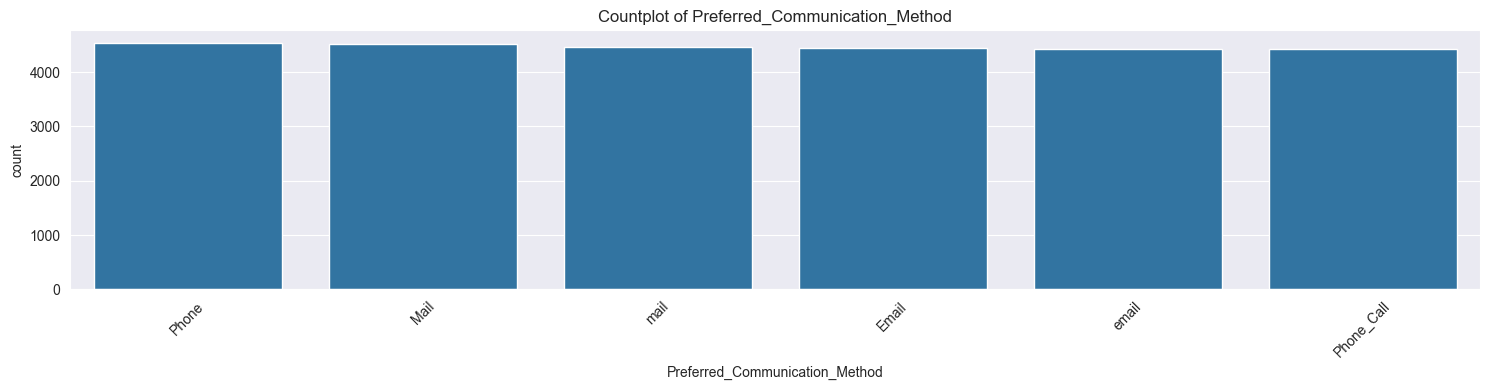

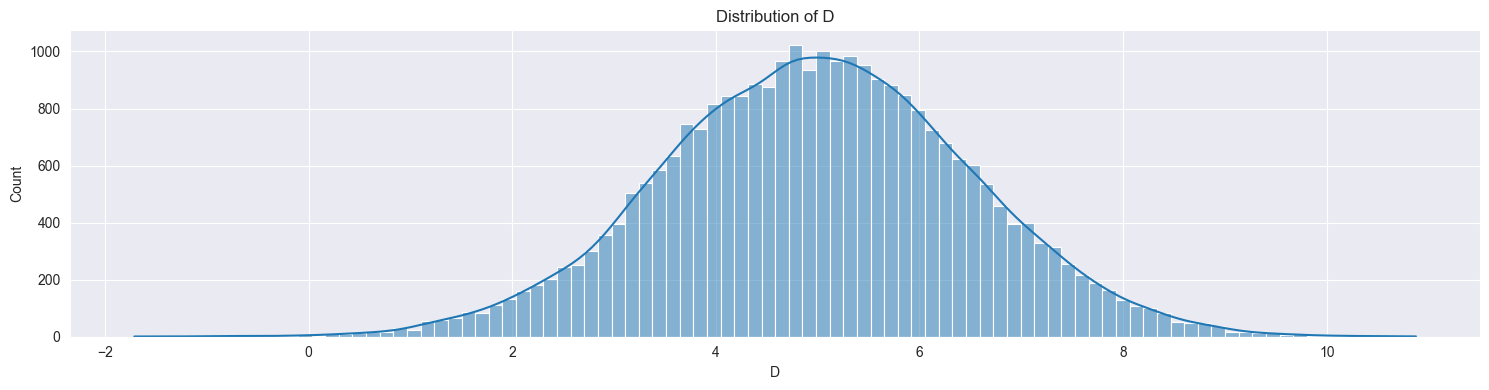

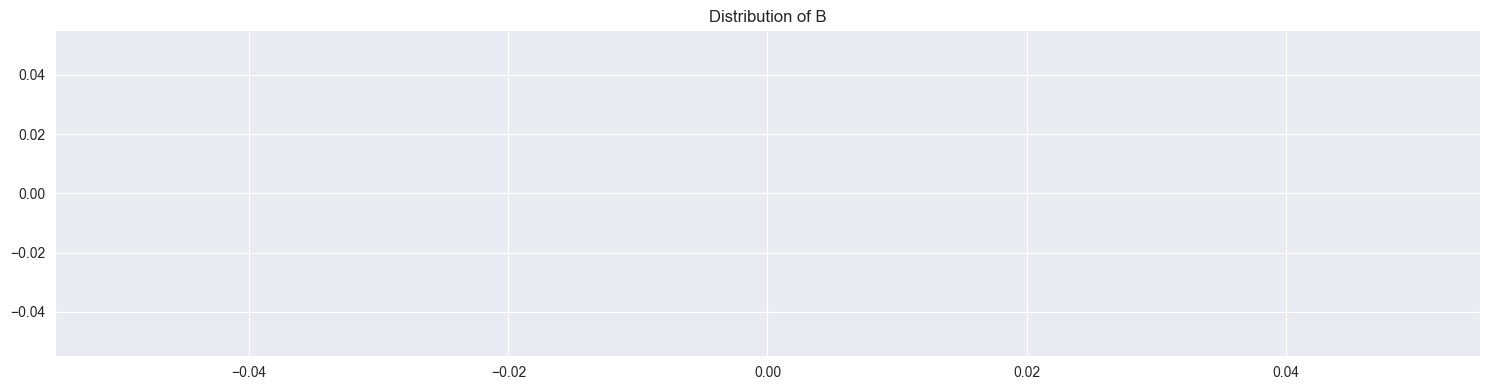

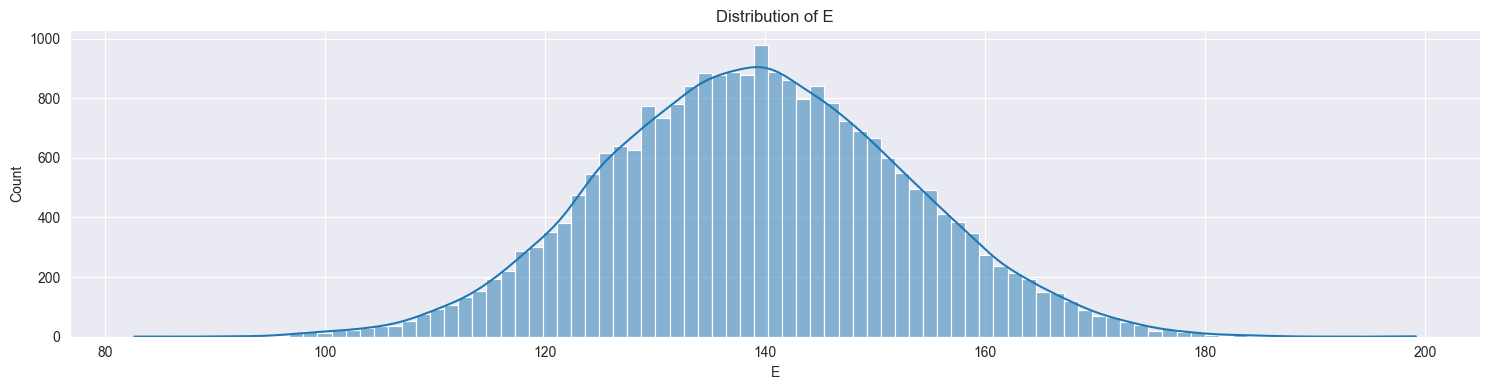

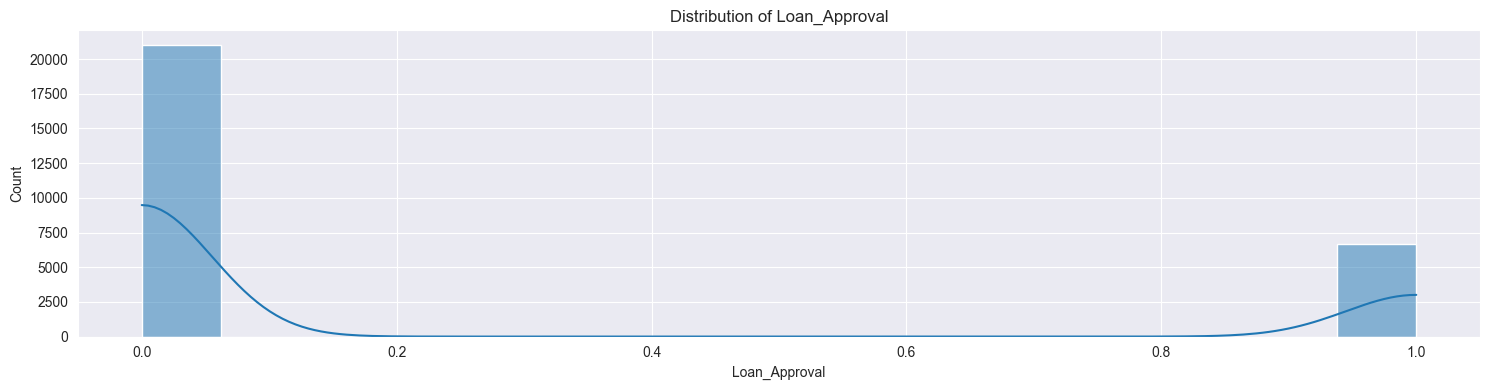

In [48]:
# Histograms and count plots of each explanatory variable

for col in train.columns:
    plt.figure(figsize=(15, 4))
    
    # For numeric variables
    if pd.api.types.is_numeric_dtype(train[col]):
        sns.histplot(train[col].dropna(), kde=True)
        plt.title(f"Distribution of {col}")
    
    # For categorical variables 
    else:
        sns.countplot(x=col, data=train, order=train[col].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f"Countplot of {col}")
    
    plt.tight_layout()
    plt.show()

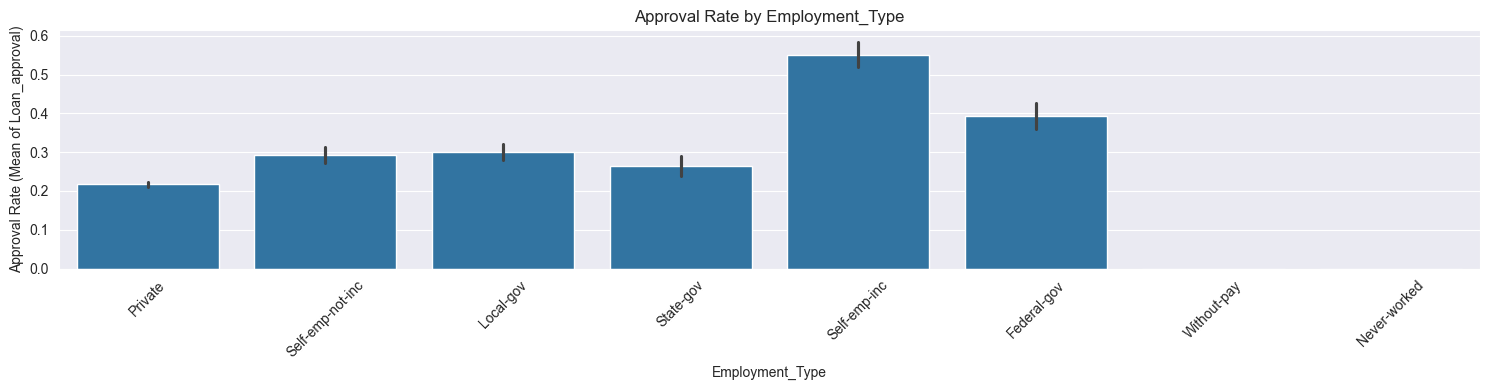

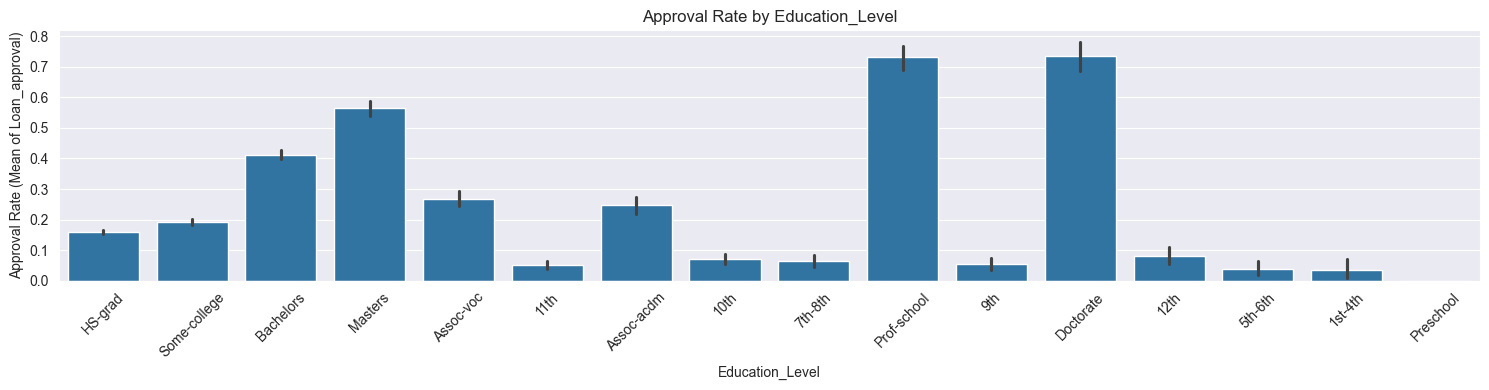

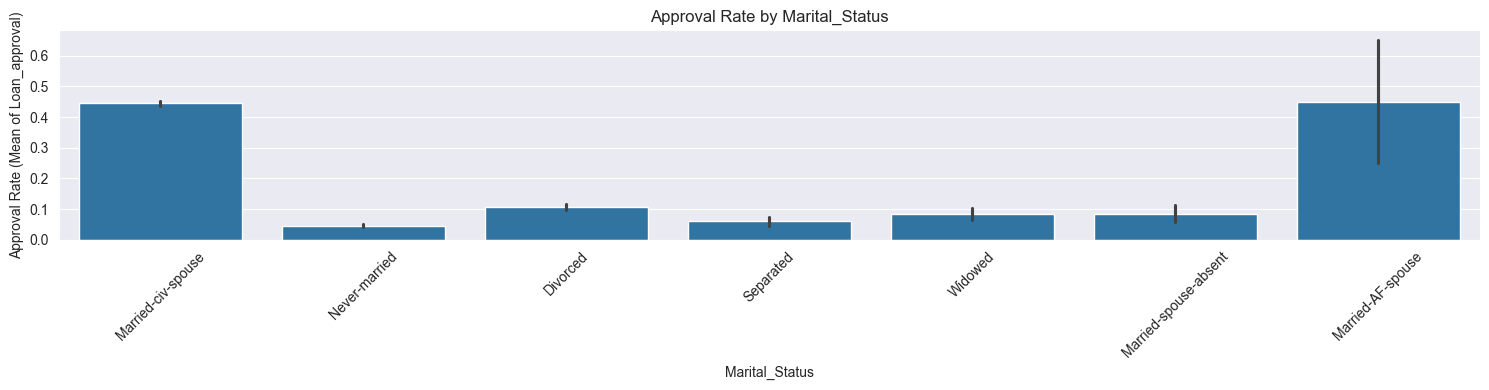

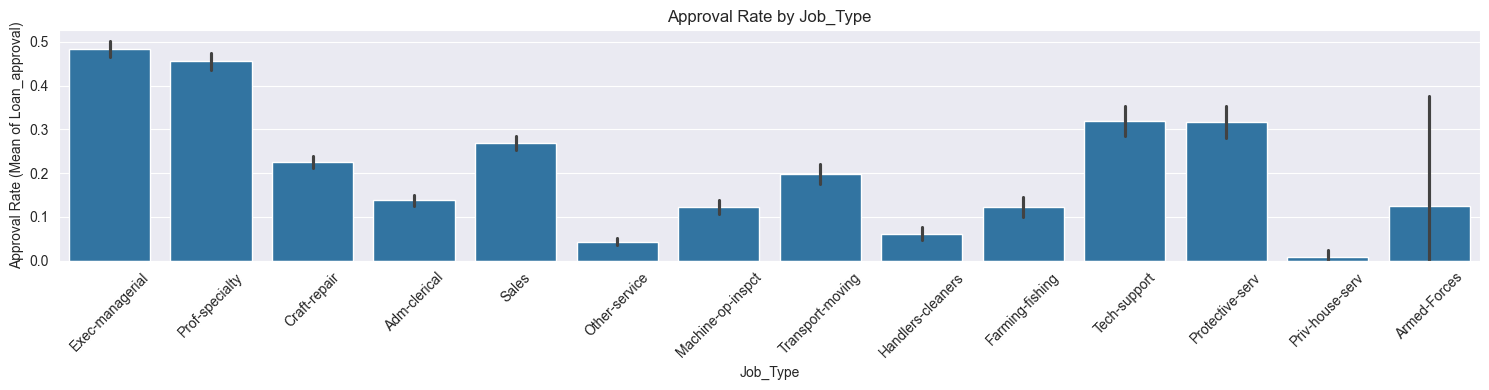

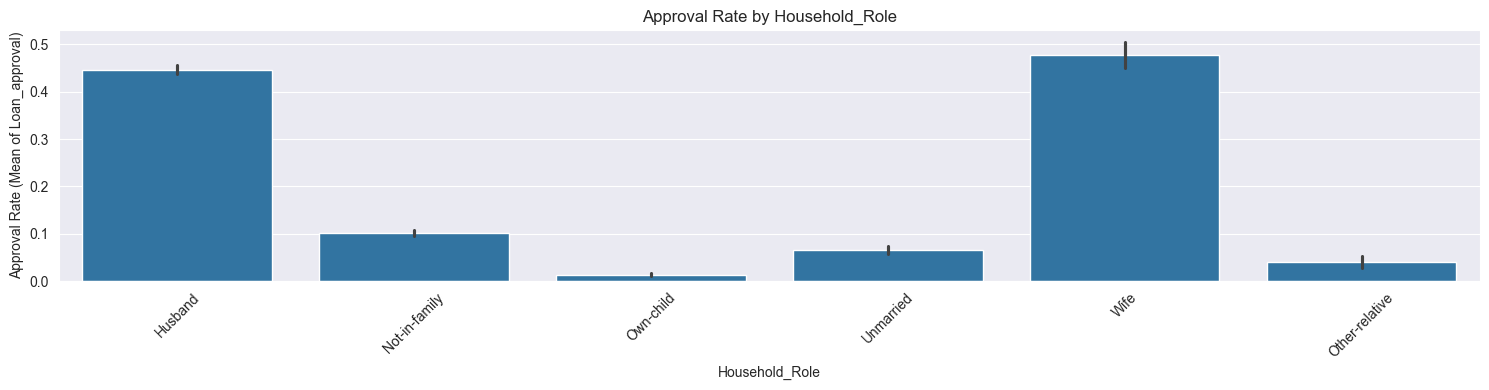

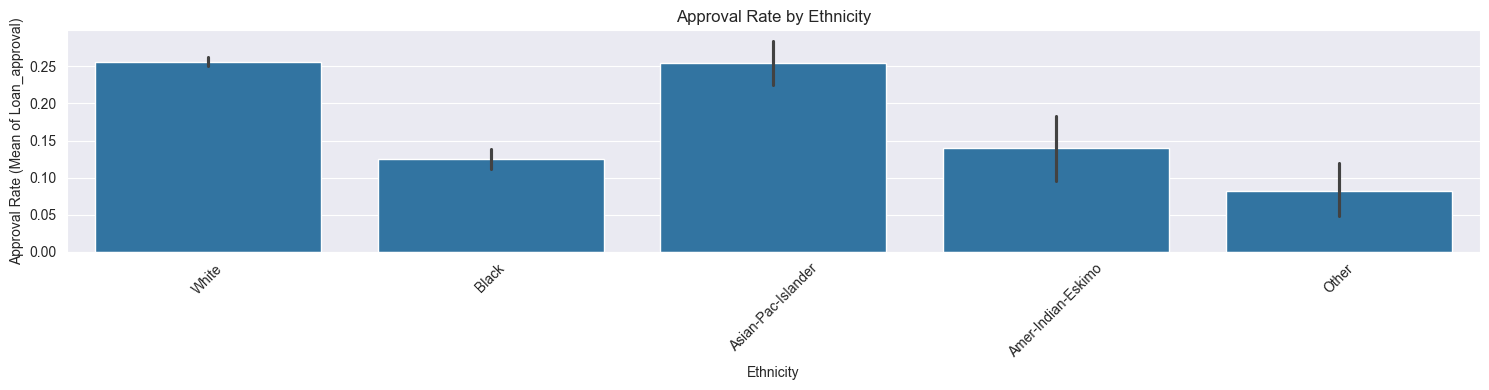

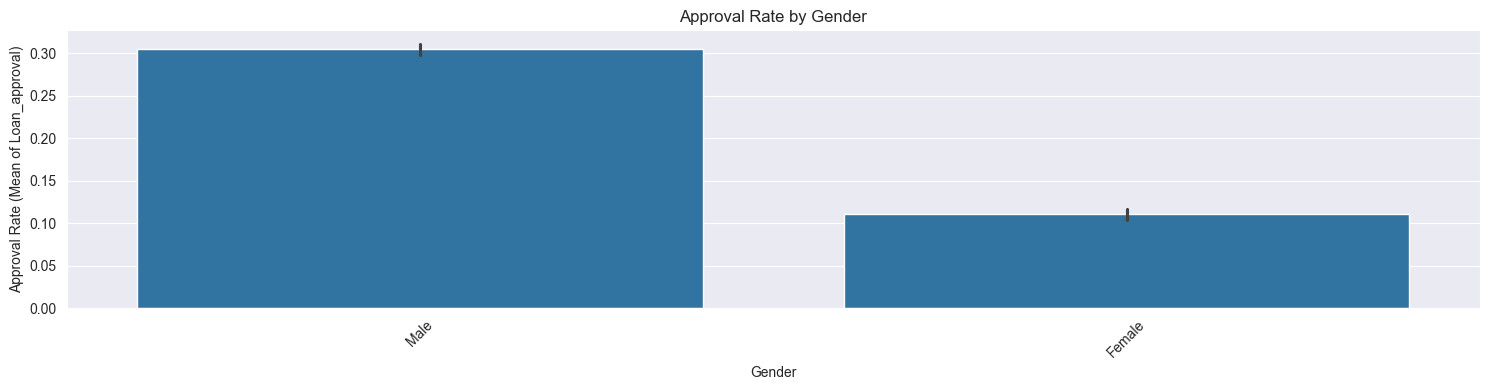

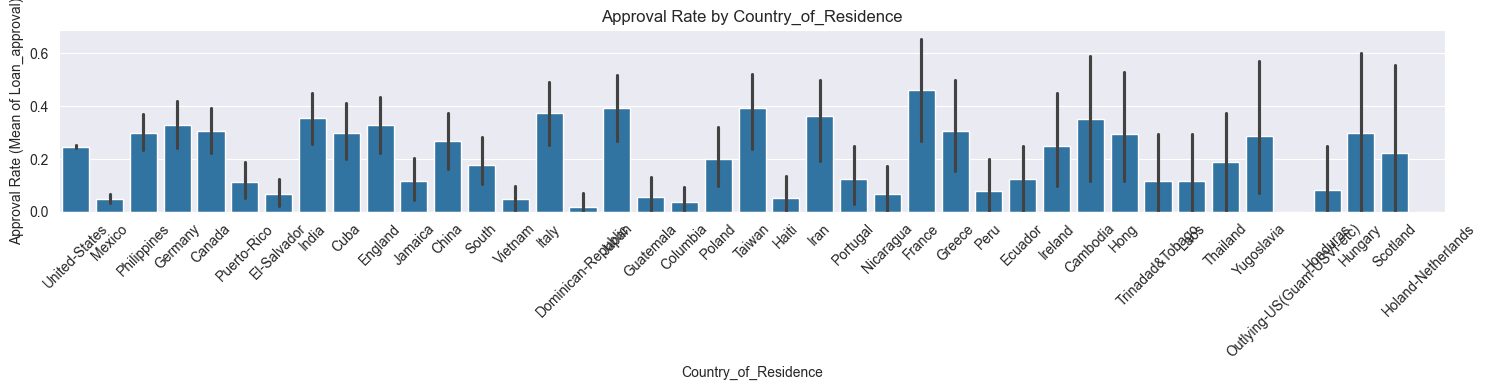

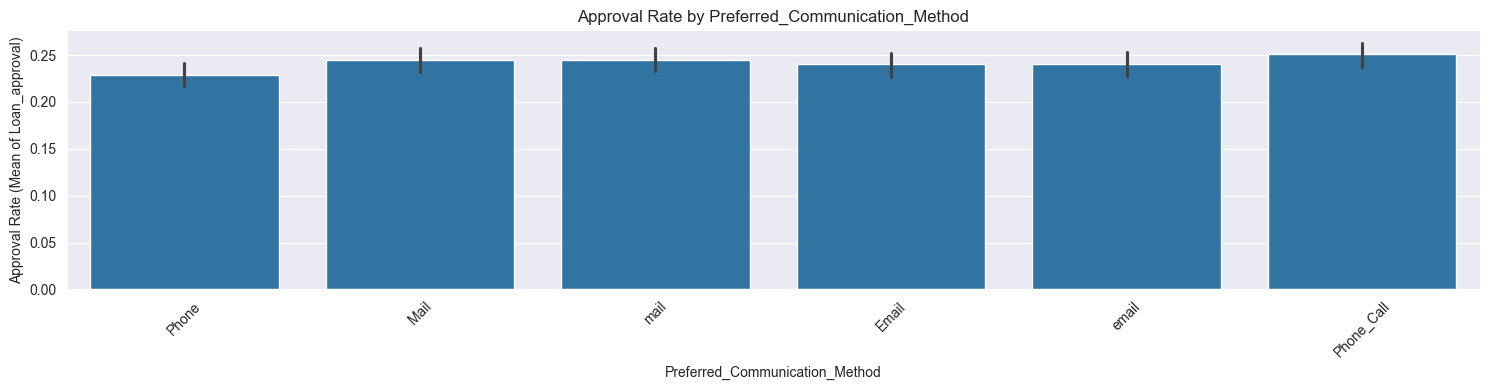

In [47]:
# Bar plots of approval rates for categorical variables

categorical_vars = [
    'Employment_Type', 'Education_Level', 'Marital_Status', 'Job_Type',
    'Household_Role', 'Ethnicity', 'Gender', 'Country_of_Residence',
    'Preferred_Communication_Method'
]

for col in categorical_vars:
    plt.figure(figsize=(15, 4))
    sns.barplot(x=col, y='Loan_Approval', data=train, estimator='mean', order=train[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Approval Rate by {col}')
    plt.ylabel('Approval Rate (Mean of Loan_approval)')
    plt.tight_layout()
    plt.show()

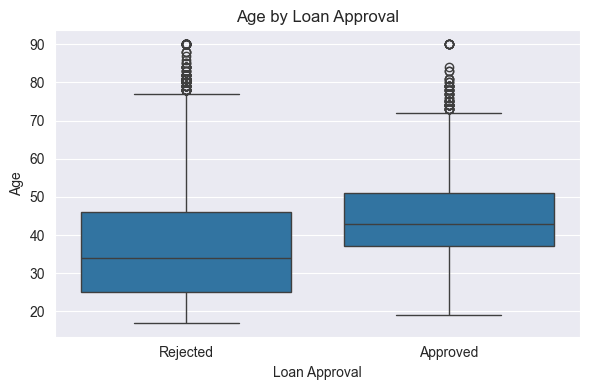

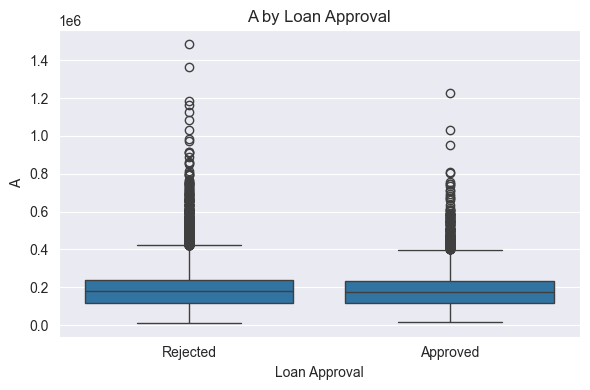

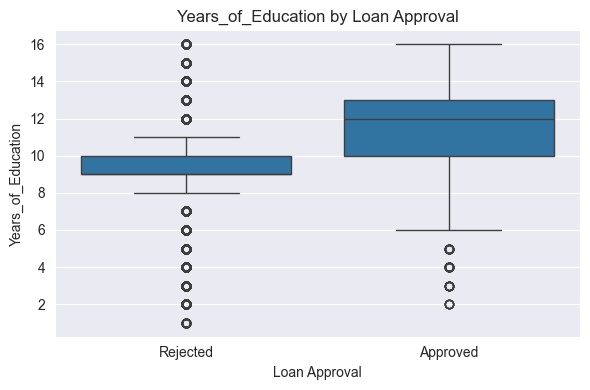

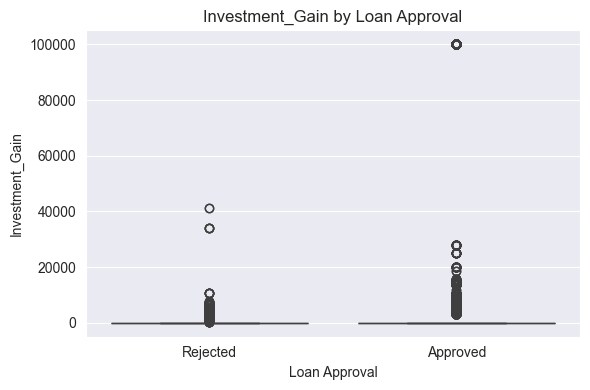

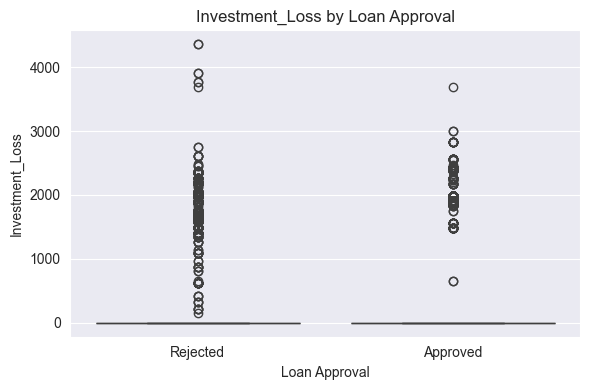

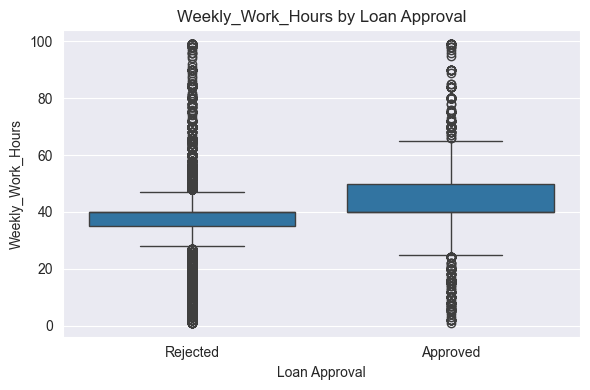

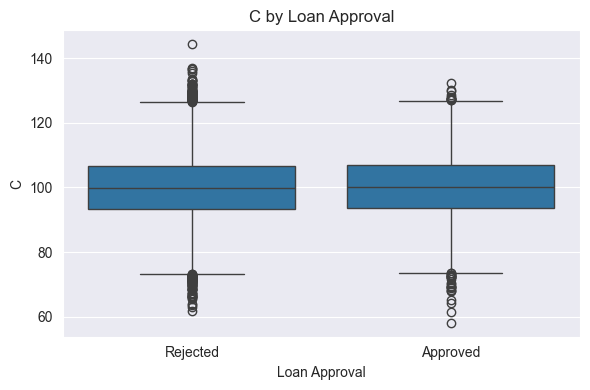

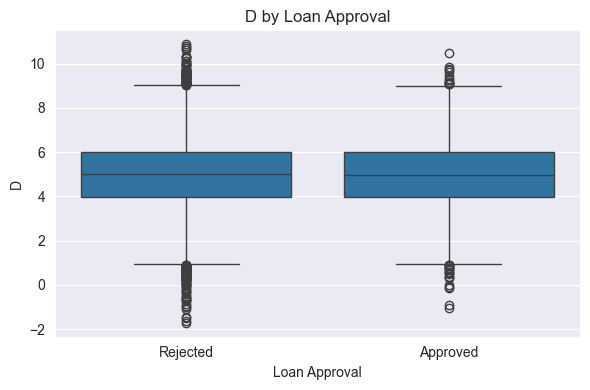

ValueError: List of boxplot statistics and `positions` values must have same the length

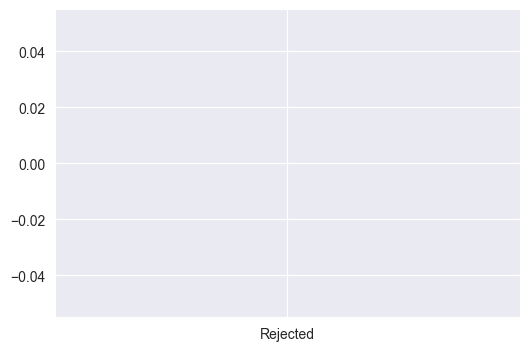

In [56]:
#Box plots of approved vs. rejected for numerical variables
train['Loan_Approval_str'] = train['Loan_Approval'].map({0: 'Rejected', 1: 'Approved'})

# Remove columns that shouldn't be plotted
numeric_cols = [col for col in train.select_dtypes(include='number').columns if col not in ['customer_id', 'Loan_Approval']]

# Create one boxplot per feature vs Loan Approval
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Loan_Approval_str', y=col, data=train)
    plt.title(f'{col} by Loan Approval')
    plt.xlabel('Loan Approval')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

**Key Insights from Feature Distributions**
1. Employment_Type, Country_of_Residence and Ethnicity are highly imbalanced.
To reduce sparsity and improve generalization, we will group the less frequent categories into broader, more meaningful groups.
2. A is right-skewed, so a log transformation may help normalize its distribution.
3. Investment_Gain and Investment_Loss are extremely skewed with large outliers, so a log transformation might help, and merging them into a single Net_Investment feature may provide a clearer signal.
4. Preferred_Communication_Method has inconsistent values due to variations in capitalization and wording (e.g., "Email" vs "email").
5. Based on the approval rate bar plot for Household_Role, we observed clear patterns across the categories.
We grouped them into three broader categories with similar approval behavior to simplify the feature and improve model stability.


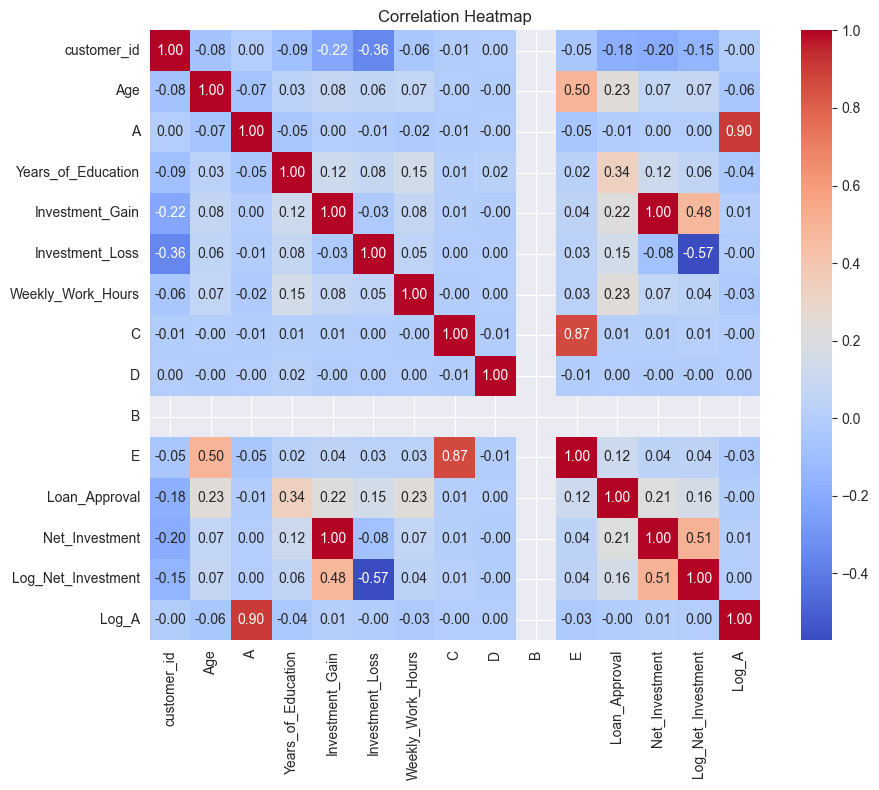

In [59]:
#Creating a heatmap

# Select only numeric columns
numeric_df = train.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [58]:
# Checking which variables are most correlated with Loan_approval (only linear) - this is the Loan_Approval row in the heatmap
numeric_df = train.select_dtypes(include='number')
correlations = numeric_df.corr()['Loan_Approval'].sort_values(ascending=False)
print(correlations)

Loan_Approval         1.000000
Years_of_Education    0.335097
Age                   0.234235
Weekly_Work_Hours     0.226344
Investment_Gain       0.223620
Net_Investment        0.211176
Log_Net_Investment    0.156407
Investment_Loss       0.152074
E                     0.124523
C                     0.010044
D                     0.000003
Log_A                -0.004413
A                    -0.011856
customer_id          -0.179697
B                          NaN
Name: Loan_Approval, dtype: float64


**Key Insights from the heat map**
1. C and E are highly correlated. we will consider dropping one of them.

We checked for overlap between Employment_Type and Job_Type using a cross-tabulation heatmap.
The results show no strong or consistent relationship between the two — most employment types are associated with a wide variety of job types.
Therefore, we concluded that the two features capture distinct information and chose to keep both.

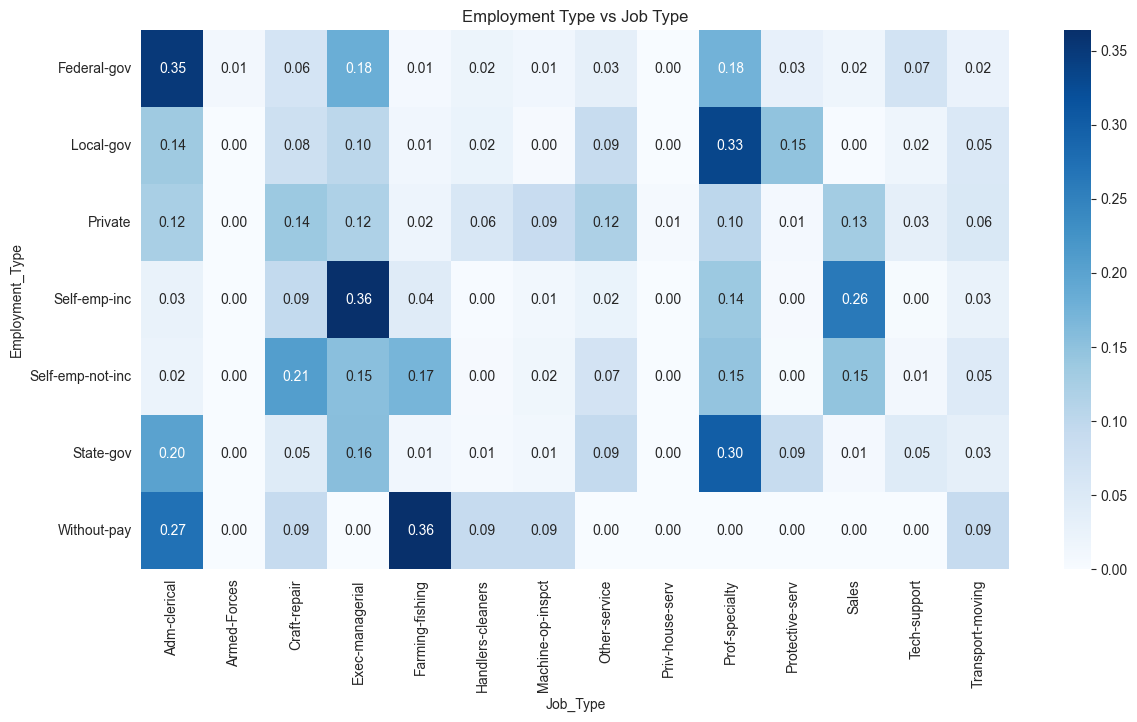

In [25]:
crosstab = pd.crosstab(train['Employment_Type'], train['Job_Type'], normalize='index')
plt.figure(figsize=(14, 7))
sns.heatmap(crosstab, cmap="Blues", annot=True, fmt=".2f")
plt.title("Employment Type vs Job Type")
plt.show()

By looking at the structure of the dataset, we noticed a few things:

1. Column B is completely empty, so we decided to remove it.
2. Preferred_Communication_Method has inconsistent entries due to differences in capitalization and wording, so we unified similar values.
3. We simplified the Country_of_Residence feature by grouping it into three categories: USA, Mexico, and Other. The vast majority of people were from the United States, and the approval rate among other countries wasn't very different.
4. We simplified the Employment_Type feature by grouping it into four categories: Private, not private and, and non-working.  The vast majority of people were private, and the noticeable difference in the approval rate was between non-private to non-working.
5. We combined Investment_Gain and Investment_Loss into a single feature, Net_Investment, to better capture overall financial status.
6. C and E are highly correlated (r = 0.87), indicating redundancy.
Neither has a strong linear correlation with the target, but E shows a slightly stronger signal (r = 0.125). Even though E has more missing values (as we will see later on), it’s still more useful, so we’ll keep E and drop C. 



In [ ]:
# 1. Removing columns B and C
train = train.drop(['B', 'C'], axis=1)
test = test.drop(['B', 'C'], axis=1)
n_columns -= 2

In [ ]:
# 2. unifying similar values in Preferred_Communication_Method:
train['Preferred_Communication_Method'] = train['Preferred_Communication_Method'].replace({
    'mail': 'Mail',
    'email': 'Email',
    'phone': 'Phone',
    'phone call': 'Phone'
})
test['Preferred_Communication_Method'] = test['Preferred_Communication_Method'].replace({
    'mail': 'Mail',
    'email': 'Email',
    'phone': 'Phone',
    'phone call': 'Phone'
})

In [ ]:
# Grouping Country_of_Residence
def group_country(country):
    if country == "United-States":
        return "USA"
    elif country == "Mexico":
        return "Mexico"
    else:
        return "Other"
    
train['Country_of_Residence'] = train['Country_of_Residence'].apply(group_country)

In [20]:
# Grouping Education_Level
def group_education(edu):
    pre_school = ['Preschool']
    school = ['1st-4th', '5th-6th', '9th', '10th', '11th', '12th', '7th-8th']
    post_hs = ['HS-grad', 'Some-college']
    assoc = ['Assoc-voc', 'Assoc-acdm']
    higher = ['Masters', 'Bachelors']
    postgraduate = ['Doctorate', 'Prof-school']
    
    if edu in pre_school:
        return 'pre_school'
    elif edu in school:
        return 'school'
    elif edu in post_hs:
        return 'post_hs'
    elif edu in assoc:
        return 'assoc'
    elif edu in higher:
        return 'higher'
    elif edu in postgraduate:
        return 'postgraduate'
    else:
        return 'Other'
    
train['Education_Level'] = train['Education_Level'].apply(group_education)

In [ ]:
def group_household_role(role):
    if role in ['Husband', 'Wife']:
        return 'Spouse'
    else:
        return 'Other'

train['Household_Role'] = train['Household_Role'].apply(group_household_role)
test['Household_Role'] = test['Household_Role'].apply(group_household_role)

In [13]:
def group_employment(emp):
    if emp == 'Private':
        return 'Private'
    elif emp in ['Self-emp-not-inc', 'Self-emp-inc', 'Local-gov', 'State-gov', 'Federal-gov']:
        return 'Not-Private'
    elif emp in ['Without-pay', 'Never-worked']:
        return 'Non-working'
    else:
        return 'Other'
    
    train['Employment_Grouped'] = train['Employment_Type'].apply(group_employment)

In [60]:
def group_ethnicity(eth):
    if eth == 'White':
        return 'White'
    elif eth == 'Black':
        return 'Black'
    else:
        return 'Other'
        

    train['Ethnicity'] = train['Ethnicity'].apply(group_ethnicity)

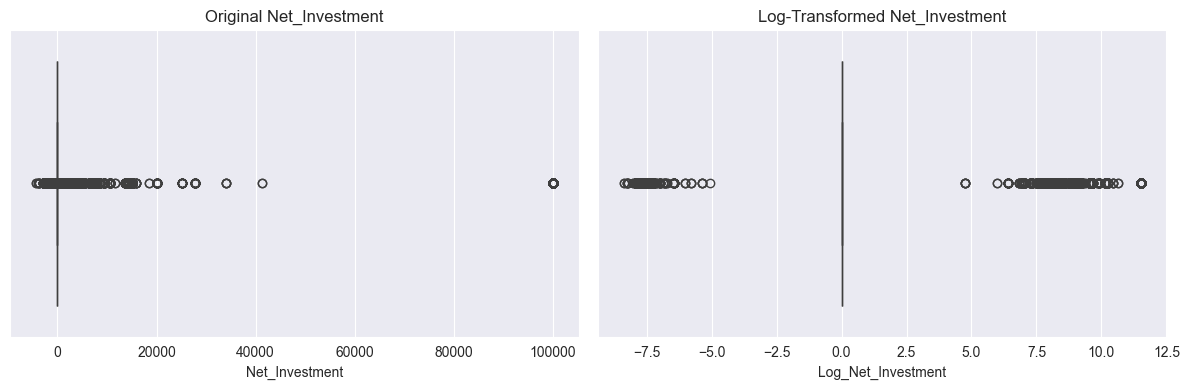

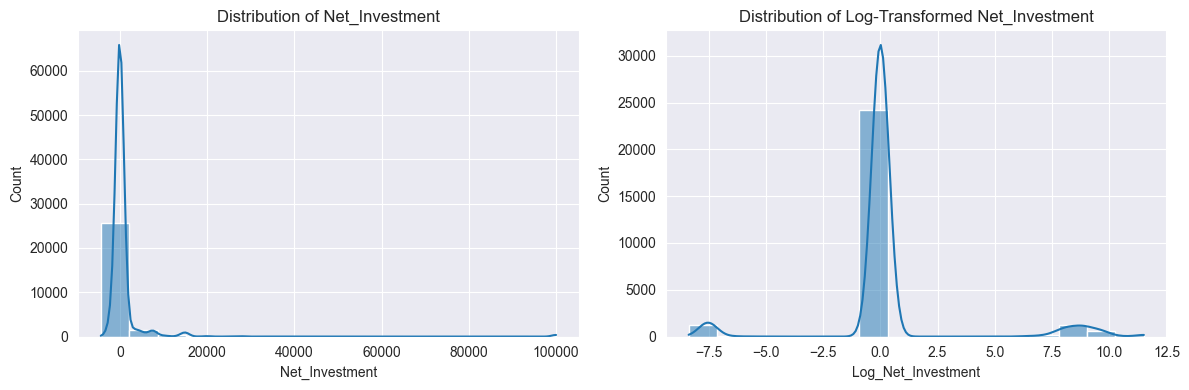

In [62]:
# Side-by-side boxplots 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=train['Net_Investment'], ax=axes[0])
axes[0].set_title('Original Net_Investment')
axes[0].set_xlabel('Net_Investment')

sns.boxplot(x=train['Log_Net_Investment'], ax=axes[1])
axes[1].set_title('Log-Transformed Net_Investment')
axes[1].set_xlabel('Log_Net_Investment')

plt.tight_layout()
plt.show()

# Side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train['Net_Investment'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Net_Investment')
axes[0].set_xlabel('Net_Investment')

sns.histplot(train['Log_Net_Investment'].dropna(), kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-Transformed Net_Investment')
axes[1].set_xlabel('Log_Net_Investment')

plt.tight_layout()
plt.show()


We applied a log transformation to Net_Investment to reduce skew and compress extreme outliers.
The resulting distribution is more symmetric, so we will keep it.


In [ ]:
# TALA LETS DECIDE: WE WILL TRY WITH BOTH AND DECIDE 
# Drop the original (non-log) Net_Investment column
train = train.drop('', axis=1)
test = test.drop('', axis=1)


We applied a log transformation to column A to reduce skew and potentially improve its relationship with the target.
However, the correlation with Loan_Approval remained low, so we won't use it.

In [66]:
pd.crosstab(train['Loan_Approval'], train['Gender'])
pd.crosstab(train['Loan_Approval'], train['Ethnicity'], normalize='index')
pd.crosstab(train['Loan_Approval'], train['Education_Level'], normalize='index')
pd.crosstab(train['Loan_Approval_str'], train['Gender'], normalize='index')

# Doesn't really help because of the unbalanced proportions. Add an explanation.


Gender,Female,Male
Loan_Approval_str,,
Approved,0.150960,0.849040
Rejected,0.386255,0.613745


In [63]:
# AFTER CHANGING 

# Checking which variables are most correlated with Loan_approval (only linear):
numeric_df = train.select_dtypes(include='number')
correlations = numeric_df.corr()['Loan_Approval'].sort_values(ascending=False)
print(correlations)

Loan_Approval         1.000000
Years_of_Education    0.335097
Age                   0.234235
Weekly_Work_Hours     0.226344
Investment_Gain       0.223620
Net_Investment        0.211176
Log_Net_Investment    0.156407
Investment_Loss       0.152074
E                     0.124523
C                     0.010044
D                     0.000003
Log_A                -0.004413
A                    -0.011856
customer_id          -0.179697
B                          NaN
Name: Loan_Approval, dtype: float64


In [52]:
count_sravan = (train['Ethnicity'] == 'White').sum()
print("Occurrences of 'sravan':", count_sravan)

Occurrences of 'sravan': 21269


## 3. Data Preprocessing
_Handle missing values, encode categorical features, normalize, etc._

**✏️ Answer in markdown:**
- Did you normalize the data? Why?
- How did you handle categorical variables?
- Did you apply PCA or feature selection?
- Did you drop or create new features?


In [50]:
# Understanding missing values - Check how many missing values there are in each column and if it has a pattern
missing = train.isnull().sum()
missing_percent = (missing / len(train)) * 100

print(missing_percent.sort_values(ascending=False))

# Plot missing value matrix
#msno.matrix(train)

B                                 100.000000
Job_Type                           12.180228
E                                  11.876716
Ethnicity                           9.986992
Employment_Type                     6.543576
C                                   4.028761
Preferred_Communication_Method      3.121838
Investment_Gain                     2.998988
Years_of_Education                  2.001734
Country_of_Residence                1.792166
Age                                 0.487787
Investment_Loss                     0.104784
customer_id                         0.000000
D                                   0.000000
Gender                              0.000000
Weekly_Work_Hours                   0.000000
Household_Role                      0.000000
Marital_Status                      0.000000
Education_Level                     0.000000
A                                   0.000000
Loan_Approval                       0.000000
dtype: float64


In [57]:
#Handling missing Ethnicity:

pd.crosstab(train['Job_Type'], train['Ethnicity'])


Ethnicity,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Job_Type,,,,,
Adm-clerical,22,99,329,17,2207
Armed-Forces,1,0,1,0,5
Craft-repair,30,68,185,17,2599
Exec-managerial,27,94,172,7,2648
Farming-fishing,8,10,32,7,655
Handlers-cleaners,20,16,132,10,795
Machine-op-inspct,12,47,201,31,1162
Other-service,25,97,404,25,1769
Priv-house-serv,0,4,23,3,79


In [62]:
train['Ethnicity'] = train['Ethnicity'].apply(group_ethnicity)


pd.crosstab(train['Job_Type'], train['Ethnicity'], normalize="columns")


Ethnicity,Black,Other,White
Job_Type,,,
Adm-clerical,0.160645,0.126313,0.117807
Armed-Forces,0.000488,0.000568,0.000267
Craft-repair,0.090332,0.121771,0.138732
Exec-managerial,0.083984,0.118081,0.141347
Farming-fishing,0.015625,0.026398,0.034963
Handlers-cleaners,0.064453,0.049390,0.042436
Machine-op-inspct,0.098145,0.075504,0.062026
Other-service,0.197266,0.117513,0.094427
Priv-house-serv,0.011230,0.006245,0.004217


The plot shows that column B is completely empty, so we should remove it. The rest of the columns have some missing values, but there doesn’t seem to be any clear pattern.

In [55]:
# Two different ways of dealing with the missing values - we will need to decide which one to use later on:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# OPTION 1: just put missing (better with stuff like trees:



# Define the columns
categorical_col = ['Job_Type', 'Ethnicity']
numerical_col = 'E'

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numerical features (mean imputation)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine both pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, [categorical_col]),
    ('num', num_pipeline, [numerical_col])
])


#notes:
C is handeled with mean bacause its distributed normally.

## 4. Model Training – Basic Models
_Start simple. Train Logistic Regression or KNN._

In [ ]:
from sklearn.linear_model import LogisticRegression

# This transforms (missing data and stuff like that) AND does the classifier as well.


model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression())
])

model.fit(train[[categorical_col]], y_train)

## 5. Model Training – Advanced Models
Choose 3 models from:
- Decision Tree
- Random Forest or AdaBoost
- Support Vector Machine
- Multi-Layer Perceptron (Neural Net)

_Include basic hyperparameter tuning or explain defaults._

## 6. Evaluation
- Build confusion matrix for at least one model
- Generate ROC curves (using K-Fold CV)
- Report AUC

**✏️ Answer in markdown:**
- Does any model overfit?
- Which model generalizes best?
- Final choice justification

## 7. Final Prediction on Test Set
_Predict probabilities (not binary labels!) and create submission file._

In [ ]:
# Example:
# final_model.predict_proba(test)[:, 1]  # ← probability of 'approved'
# submission = pd.DataFrame({
#     'customer_id': test['customer_id'],
#     'loan_approval': predictions
# })
# submission.to_csv('Submission_group_32.csv', index=False)

## 8. Appendix / Extra Notes
_Use this area for extra analysis, failed attempts, or ideas you explored._